# Наша n-ая свёрточная нейросеть 

Пришло время построить нашу первую свёрточную нейросеть. Будем использовать для этого датасет [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) (Canadian Institute for Advanced Research). Он включает в себя картинки из 10 разных классов: самолёты, машины, птицы, кошки, олени, собаки, лягушки, лошади, корабли, грузовики.   

<img src="http://www.pvsm.ru/images/2016/11/18/optimizaciya-neirosetevoi-platformy-Caffe-dlya-arhitektury-Intel-3.png" style="width:50%">

Всего $60 000$ цветных картинок размера $32 \times 32$. В каждом из классов ровно по $6000$ картинок.  Есть расширение этого датасета, CIFAR_100. Думаю, что по названию вы догадались, что в нём сто видов картинок. Попробовать обуздать этот датасет можно, подгрузив его следущими командами: 

```from keras.datasets import cifar100
   (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')```

In [1]:
# подгружаем пакеты
import numpy as np
import random
from tqdm import tqdm

import tensorflow as tf
import keras
from keras import backend as K

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


## 1. Скачиваем и готовим данные

Приготовьте на своём компухтере местечко для датасета. Он достаточно громоздкий и включает 60 000 картинок. Кстати говоря, если очень хочется, можете принять участие [в стареньком соревновании на Kagle,](https://www.kaggle.com/c/cifar-10) связанным с этим датасетом. Там же на форуме можно найти интересный код. :) 

In [2]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


Помним, что у нас всего 10 классов.

In [4]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

Нарисуем несколько рандомных картинок из тренировочной выборки. 

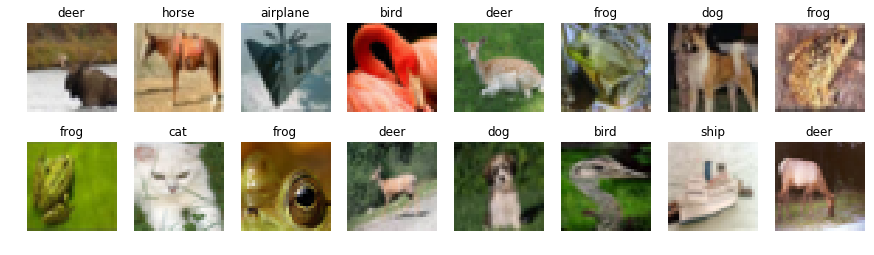

In [5]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

Отлично! Как вы помните, если пронормаровать данные, то сетка будет сходиться на порядок быстрее. 

Также, как вы помните из предыдущих скриптов, картинка - это тензор из циферок. Каждая циферка сообщает нам о яркости конкретного пикселя. Яркость измеряется по шкале от 0 до 255. В связи с этим фактом, нормализация будет немного странной: 

$$
x_{norm} = \frac{x}{255}
$$

Также мы помним, что классы нужно конвертировать одним горячи кодированием (one-hot encoding) в набор из дамми-переменных. 

In [6]:
# делай раз
x_train2 = x_train/255
x_test2 =  x_test/255

# делай два! 
y_train2 = keras.utils.to_categorical(y_train,10)
y_test2 = keras.utils.to_categorical(y_test,10)

## 2.  Выбираем для нашей нейросети архитектуру

Свёрточная нейронная сеть строится из нескольких разных типов слоёв: 

* [Conv2D](https://keras.io/layers/convolutional/#conv2d) - Конволюция:
    - **filters**: число выходных каналов; 
    - **kernel_size**: размер окна для свёртки;
    - **padding**: padding="same" добавляет нулевую каёмку по краям картинки, чтбы после свёртки размеры картинки не изменялись; padding='valid' ничего не добавляет;
    - **activation**: "relu", "tanh", etc.
    - **input_shape**: размер входа
* [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - макспулинг
* [Flatten](https://keras.io/layers/core/#flatten) - разворачивает картинку в вектор 
* [Dense](https://keras.io/layers/core/#dense) - полносвязный слой (fully-connected layer)
* [Activation](https://keras.io/layers/core/#activation) - функция активации
* [LeakyReLU](https://keras.io/layers/advanced-activations/#leakyrelu) - leaky relu активация
* [Dropout](https://keras.io/layers/core/#dropout) - дропаут.


В модели, которую мы определим ниже, на вход будет идти тензоры размера __(None, 32, 32, 3)__ и __(None, 10)__. На выходе мы будем получать вероятноть того, что объект относится к конкретному классу. Разменость __None__ заготовлена для размерности батча. 

In [7]:
# подгружаем важные строительные блоки
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, InputLayer
from keras.layers.advanced_activations import LeakyReLU

Соберите сетку со следующей архитектурой: 

* Четыре свёрточных слоя с ядром $3 \times 3$ и числом фильтров $16, 32, 32, 64$. Используйте same padding. 
* Слой пулинга размера $2 \times 2$. после каждыйх двух свёрточных слоёв. 
* В качестве функции активации используйте LeakyReLU с параметром $0.1$. Используйте её после каждого слоя. 
* Разверните сеть в полносвязную, добавьте слой с $256$ нейронами.
* На выходе используйте __Softmax__
* После полносвязного слоя добавьте __Dropout__ с вероятностью $0.5$, после каждого макспулинга добавьте __Dropout__ с вероятностью $0.25$. 

In [8]:
def make_model():
    """
    Определите архитектуру свой сетки внутри этой функции
    """
    model = Sequential()
    # Для первого слоя важно не забыть указать "input_shape"
    model.add(Conv2D(16, kernel_size=(3, 3),padding="same", input_shape=(32, 32, 3)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(32, kernel_size=(3,3),padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D( pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, kernel_size=(3,3),padding="same"))
    model.add(LeakyReLU(0.1))    
    model.add(Conv2D(64, kernel_size=(3,3),padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D( pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.1))    
    model.add(Dropout(0.5))                 
    model.add(Dense(10))  # Последний слой с нейронами для каждого класса 
    model.add(Activation("softmax"))  # Итоговые вероятности
    return model

In [9]:
# Взглянем на нашу модель
model = make_model()
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
con

Огромное количество параметров нам предстоит оценить. 

## 3. Оцениваем модель

Обучение модели может занять примерно 4-8 минут на каждой эпохе. В случае, если на картинке качество модели не будет расти, придётся переопределять параметры вроде скорости обучения. Если и это не поможет, придётся думать о новой архитектуре. 

In [10]:
INIT_LR = 5e-3    # Скорость обучения 
BATCH_SIZE = 32   # Размер батча
EPOCHS = 10       # Эпохи 

model = make_model()  # Создаём модель 

# Выбираем для модели оптимизатор и собираем её
model.compile(
    loss='categorical_crossentropy',  # Кросс энтропия обычно используется как функция потерь для 
                                      # задачи многоклассовой классификации
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # SGD наш оптимизатор 
    metrics=['accuracy']  # Будем в ходе обучения запоминать точность прогнозов
)

# Новая фишка! Функция, которая корректирует скорость обучения каждую эпоху 
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# Мы готовы к обучению 
history = model.fit(
    x_train2, y_train2,    # Данные
    batch_size=BATCH_SIZE, # Сколько сетка кушает за раз 
    epochs=EPOCHS,         # Сколько полных проходов по данным
    # Колбэки. Через них реализован всякий полезный функционал. В прошлый раз мы 
    # с помощью этого параметра делали early stopping 
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],
    validation_data=(x_test2, y_test2),  # Немножко валидации :) 
    shuffle=True
)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 167s 3ms/step - loss: 1.4476 - acc: 0.4763 - val_loss: 1.0351 - val_acc: 0.6267
Epoch 2/10
50000/50000 [==============================] - 162s 3ms/step - loss: 1.0345 - acc: 0.6348 - val_loss: 0.8925 - val_acc: 0.6843
Epoch 3/10
50000/50000 [==============================] - 170s 3ms/step - loss: 0.8740 - acc: 0.6924 - val_loss: 0.7912 - val_acc: 0.7218
Epoch 4/10
50000/50000 [==============================] - 163s 3ms/step - loss: 0.7807 - acc: 0.7259 - val_loss: 0.7817 - val_acc: 0.7274
Epoch 5/10
50000/50000 [==============================] - 157s 3ms/step - loss: 0.7155 - acc: 0.7503 - val_loss: 0.6954 - val_acc: 0.7610
Epoch 6/10
50000/50000 [==============================] - 165s 3ms/step - loss: 0.6526 - acc: 0.7710 - val_loss: 0

In [11]:
# Сохраняем веса модели в файл ибо модель училась долго 
model.save_weights("cifar_10_weights.h5")

In [12]:
# Можем подгрузить веса назад, если случилась беда и комп отрубило 
model = make_model()
model.load_weights("cifar_10_weights.h5")

Построим как проходил процесс обучения и какого качества нам удалось добиться. 

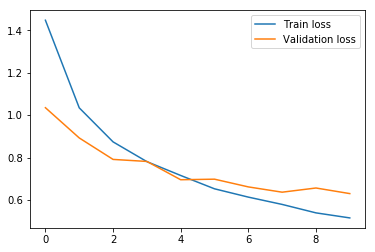

In [13]:
start = 0
plt.plot(history.history['loss'][start:])
plt.plot(history.history['val_loss'][start:])
plt.legend(['Train loss', 'Validation loss'])

In [14]:
y_pred_test = model.predict_proba(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

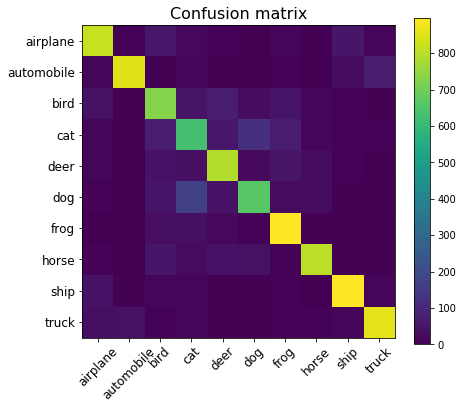

Test accuracy: 0.7949


In [15]:
# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

Хммм... 80% это неплохо. Судя по матрице, модель не совершает каких-то систематических ошибок в одном из конкретных классов. Например, она не путает лошадей с оленями. Попробуем сделать пару предсказаний и посмотреть на картинки. 

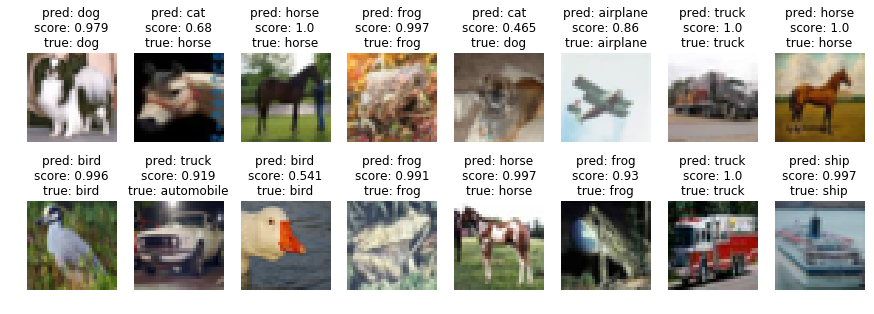

In [16]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))    # Выбираем рандомный объект из теста 
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)  # выделяем место для картинки 
        ax.grid('off')                                      # октлючаем решётку 
        ax.axis('off')                                      # отключаем оси 
        ax.imshow(x_test[random_index, :])                  # рисуем картинку 
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]  # истиный класс
        pred_proba = y_pred_test_max_probas[random_index]                # вероятность 
        true_label = cifar10_classes[y_test[random_index, 0]]            # предсказанный класс
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label    # Подписываем картинки 
        ))
plt.show()

## 4. Data augmentation

Попробуем обучить ту же модель, но искуственно расширяя набор данных за счёт [случайных искажений.](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/)

In [17]:
from keras.preprocessing.image import ImageDataGenerator

* `rotation_range`  значение в градусах (0-180), диапазон, в пределах которого произвольно вращаются изображения;
* `width_shift` и `height_shift` это диапазоны (в долях от общей ширины или высоты), в пределах которых можно произвольно переводить изображения по вертикали или горизонтали;
* `rescale` это коэффициент скалирования, на который мы умножаем наши данные перед каждой модернизацией;
* `shear_range` диапазон для рандомных сдвигов
* `zoom_range` для случайного масштабирования внутри фотографий
* `horizontal_flip` для переворачивания половины изображения по горизонтали
* `fill_mode` стратегия для заполнения вновь появившихся пикселей

In [18]:
datagen = ImageDataGenerator(
        rotation_range=0,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rescale=255,
        shear_range=0,
        zoom_range=0.1,
        horizontal_flip=True)

In [19]:
datagen.fit(x_train2)

Number of images returned by iterator: 15


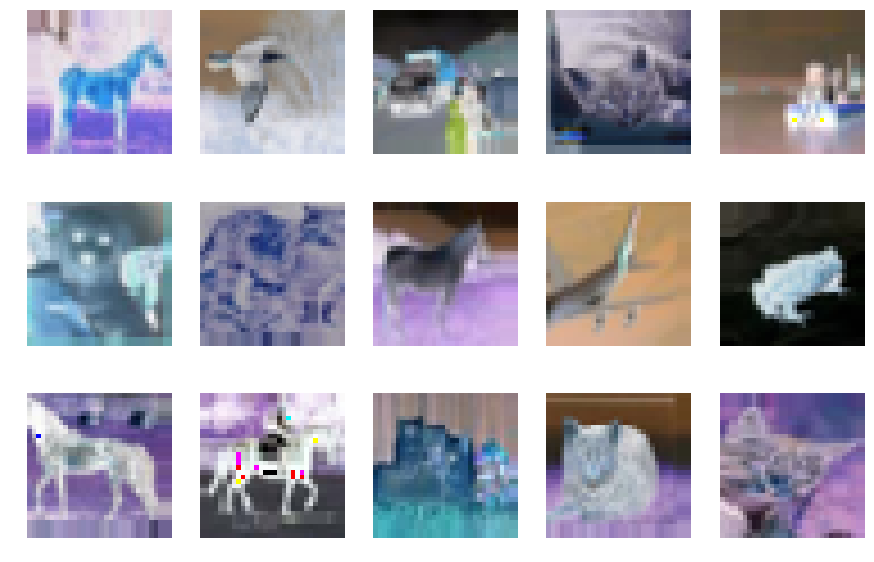

In [20]:
it = datagen.flow(x_train2, y_train2, batch_size=15) # итератор 

images, categories = it.next()
print("Number of images returned by iterator:", len(images))

fig = plt.figure(figsize=(15, 10))
for i in range(15):
    plt.subplot(3, 5, i+1)
    im = images[i]
    c = np.where(categories[i] == 1)[0][0] # convert one-hot to regular index
    plt.imshow(im)
    plt.axis('off')

Number of images returned by iterator: 15


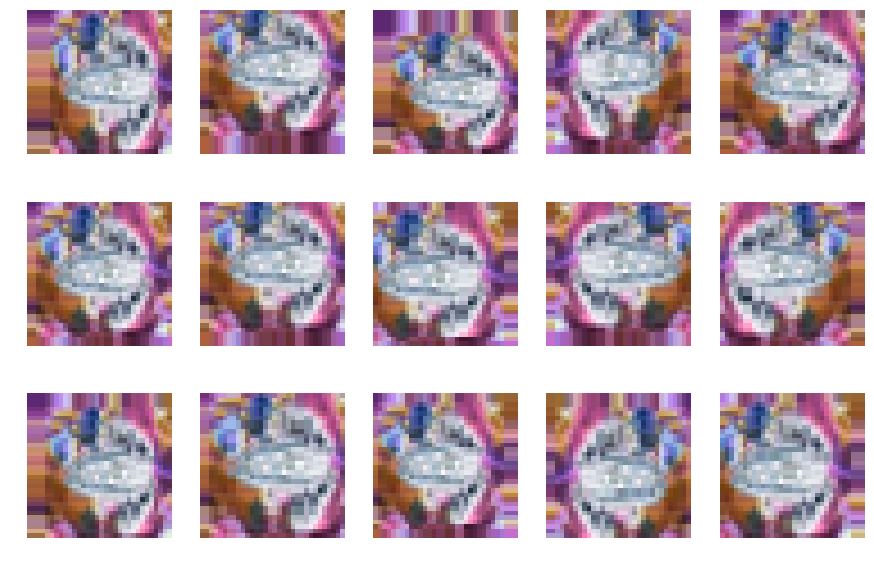

In [21]:
it = datagen.flow(np.array(15*[x_train2[200]]),np.array(15*[y_train2[200]]), batch_size=15) # итератор 

images, categories = it.next()
print("Number of images returned by iterator:", len(images))

fig = plt.figure(figsize=(15, 10))
for i in range(15):
    plt.subplot(3, 5, i+1)
    im = images[i]
    c = np.where(categories[i] == 1)[0][0] # convert one-hot to regular index
    plt.imshow(im)
    plt.axis('off')

Собираем вместе с нашим генератором нейронку. 

In [22]:
model =  make_model()
  
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

datagen.fit(x_train2)

In [25]:
# учим модель на сгенерированных батчах 
dgen = datagen.flow(x_train2, y_train2, batch_size=32)

hist = model.fit_generator(
    dgen,
    samples_per_epoch = x_train2.shape[0],
    nb_epoch = 5,
    validation_data=(x_test2, y_test2),
    verbose = 1
)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=1562, epochs=5)`
  if __name__ == '__main__':


Epoch 1/5
1562/1562 [==============================] - 159s 102ms/step - loss: 2.8846 - acc: 0.8200 - val_loss: 1.0087 - val_acc: 0.8200
Epoch 2/5
1562/1562 [==============================] - 156s 100ms/step - loss: 2.8851 - acc: 0.8200 - val_loss: 1.0087 - val_acc: 0.8200
Epoch 3/5
1562/1562 [==============================] - 152s 97ms/step - loss: 2.8853 - acc: 0.8200 - val_loss: 1.0087 - val_acc: 0.8200
Epoch 4/5
1562/1562 [==============================] - 162s 104ms/step - loss: 2.8855 - acc: 0.8200 - val_loss: 1.0087 - val_acc: 0.8200
Epoch 5/5
1562/1562 [==============================] - 149s 95ms/step - loss: 2.8858 - acc: 0.8200 - val_loss: 1.0087 - val_acc: 0.8200


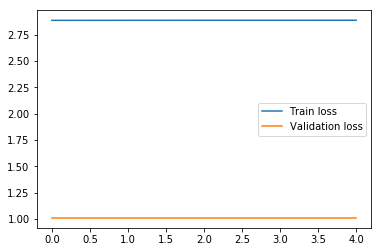

In [31]:
start = 0
plt.plot(hist.history['loss'][start:])
plt.plot(hist.history['val_loss'][start:])
plt.legend(['Train loss', 'Validation loss'])

In [27]:
y_pred_test = model.predict_proba(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

Test accuracy: 0.1


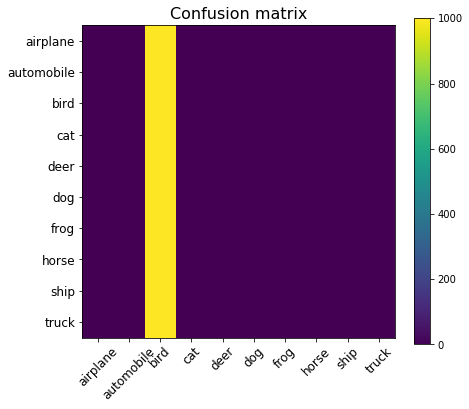

Test accuracy: 0.1


In [28]:
# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

Мне лениво ставить эксперимены :) Это на вашей совести и чести. А я бесчестен. 